In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
from plot_result import plot_result

In [2]:
df=pd.read_csv("../../data/merged/len3_prod_mon_Q_agg_drop_never.csv",encoding="shift-jis",index_col=0)
df["prod_date"]

0       2009-01-31
1       2009-02-28
2       2009-03-31
3       2009-04-30
4       2009-05-31
           ...    
4194    2022-08-31
4195    2022-09-30
4196    2022-10-31
4197    2022-11-30
4198    2022-12-31
Name: prod_date, Length: 4199, dtype: object

Estimation

In [3]:
df=pd.concat([df,pd.get_dummies(df["month"],prefix="mon")],axis=1)
df["mon_1"]

0       1
1       0
2       0
3       0
4       0
       ..
4194    0
4195    0
4196    0
4197    0
4198    0
Name: mon_1, Length: 4199, dtype: uint8

In [4]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#前処理
df.replace('-',"0",inplace=True)
df["otc_pro_agg"].replace(",","",regex=True,inplace=True)
df["rx_pro_agg"].replace(",","",regex=True,inplace=True)
# df["stock_otc_lag"].replace(",","",regex=True,inplace=True)
# df["stock_rx_lag"].replace(",","",regex=True,inplace=True)
# fillna
df["otc_pro_agg"].fillna(0,inplace=True)
df["rx_pro_agg"].fillna(0,inplace=True)
# df["stock_otc_lag"].fillna(0,inplace=True)
# df["stock_rx_lag"].fillna(0,inplace=True)

df["otc_pro_agg"]=df["otc_pro_agg"].astype(int)
df["rx_pro_agg"]=df["rx_pro_agg"].astype(int)
# df["stock_otc_lag"]=df["stock_otc_lag"].astype(int)
# df["stock_rx_lag"]=df["stock_rx_lag"].astype(float)
#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_pro_agg"]>0]
df=df.loc[df["rx_pro_agg"]>0]
# df=df.loc[df["stock_otc_lag"]>0]
# df=df.loc[df["stock_rx_lag"]>0]

# make log columns
df["log_rx_pro_agg"]=np.log(df["rx_pro_agg"])
df["log_otc_pro_agg"]=np.log(df["otc_pro_agg"])
# df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"])
# df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"])

# make year trend
df["year_trend"]=df["year"]-2008

In [5]:
# change to the datetime format
df['prod_date'] = pd.to_datetime(df["prod_date"], format='%Y-%m-%d')
# df=df.set_index(["id","prod_date"])
df=df.set_index(["id","year"])

df.info()
# make this to paneldata
df=PanelData(df,convert_dummies=False)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2553 entries, (114, 2009) to (799, 2022)
Columns: 256 entries, month to year_trend
dtypes: datetime64[ns](1), float64(11), int32(2), int64(218), object(12), uint8(12)
memory usage: 4.8+ MB


(256, 14, 21)

In [6]:
months="+mon_1+mon_2+mon_3+mon_4+mon_5+mon_6+mon_7+mon_8+mon_9+mon_10+mon_11+mon_12"
ytrend="+year_trend"

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

## RX

In [7]:
before_p=10*4
after_p=15*4
elapsed = ''.join(["+elapsed_m" + str(i) for i in range(before_p, 1, -1)])
elapsed=elapsed+''.join(["+elapsed_" + str(i) for i in range(0,after_p+1)])
print(elapsed)


+elapsed_m40+elapsed_m39+elapsed_m38+elapsed_m37+elapsed_m36+elapsed_m35+elapsed_m34+elapsed_m33+elapsed_m32+elapsed_m31+elapsed_m30+elapsed_m29+elapsed_m28+elapsed_m27+elapsed_m26+elapsed_m25+elapsed_m24+elapsed_m23+elapsed_m22+elapsed_m21+elapsed_m20+elapsed_m19+elapsed_m18+elapsed_m17+elapsed_m16+elapsed_m15+elapsed_m14+elapsed_m13+elapsed_m12+elapsed_m11+elapsed_m10+elapsed_m9+elapsed_m8+elapsed_m7+elapsed_m6+elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+elapsed_16+elapsed_17+elapsed_18+elapsed_19+elapsed_20+elapsed_21+elapsed_22+elapsed_23+elapsed_24+elapsed_25+elapsed_26+elapsed_27+elapsed_28+elapsed_29+elapsed_30+elapsed_31+elapsed_32+elapsed_33+elapsed_34+elapsed_35+elapsed_36+elapsed_37+elapsed_38+elapsed_39+elapsed_40+elapsed_41+elapsed_42+elapsed_43+elapsed_44+elapsed_45+elapsed_46+elapsed_47+elapsed_48+elapsed_49

                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
elapsed_m40        -0.1130     0.1463    -0.7721     0.4401     -0.3998      0.1739
elapsed_m39        -0.2288     0.1264    -1.8096     0.0705     -0.4767      0.0191
elapsed_m38        -0.4016     0.2618    -1.5340     0.1251     -0.9149      0.1118
elapsed_m37        -0.1610     0.1212    -1.3288     0.1840     -0.3986      0.0766
elapsed_m36        -0.2347     0.1265    -1.8556     0.0636     -0.4827      0.0133
elapsed_m35        -0.1747     0.1250    -1.3973     0.1625     -0.4199      0.0705
elapsed_m34        -0.1810     0.1318    -1.3734     0.1698     -0.4395      0.0775
elapsed_m33        -0.1827     0.1057    -1.7280     0.0841     -0.3900      0.0246
elapsed_m32        -0.0940     0.1356    -0.6931     0.4883     -0.3598     

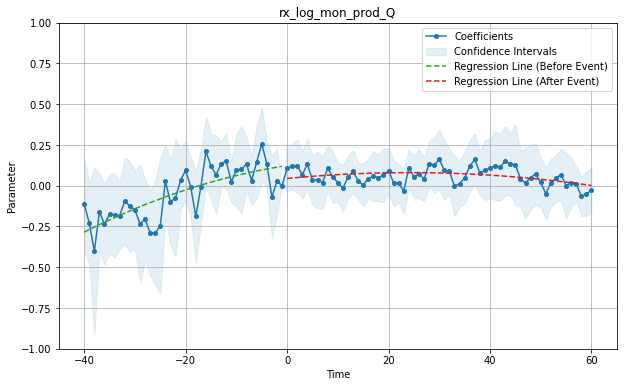

In [8]:
# take log
formula="log_rx_pro_agg ~ "+elapsed


# log_stock_rx_lag
# formula+=" + log_stock_rx_lag"
# ytrend
# formula+=ytrend
# months
formula+=months
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"
# fixed effects
formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True,check_rank=False)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="rx_log_mon_prod_Q",title="rx_log_mon_prod_Q",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)

### OTC

                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
elapsed_m40         0.4006     0.2768     1.4473     0.1480     -0.1422      0.9434
elapsed_m39        -0.3714     0.5703    -0.6512     0.5150     -1.4896      0.7469
elapsed_m38         0.3121     0.3477     0.8977     0.3695     -0.3697      0.9940
elapsed_m37         0.5204     0.3019     1.7237     0.0849     -0.0716      1.1124
elapsed_m36         0.8274     0.4758     1.7389     0.0822     -0.1057      1.7605
elapsed_m35         0.3636     0.3097     1.1740     0.2405     -0.2437      0.9709
elapsed_m34         0.1438     0.3509     0.4098     0.6820     -0.5444      0.8320
elapsed_m33         0.1981     0.5468     0.3623     0.7172     -0.8741      1.2702
elapsed_m32         0.6663     0.3430     1.9428     0.0522     -0.0062     

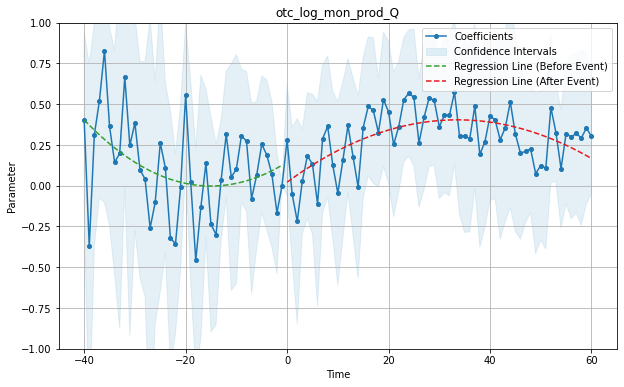

In [9]:
# take log

# till 20
# formula="log_otc_pro_agg ~ elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+elapsed_16+elapsed_17+elapsed_18+elapsed_19+elapsed_20+generic_per+TimeEffects+EntityEffects"

# take log
formula="log_otc_pro_agg ~ "+elapsed


# log_stock_rx_lag
# formula+=" + log_otc_rx_lag"
# ytrend
# formula+=ytrend
# months
formula+=months
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"

formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
# print(res_fe)
plot_result(res_fe,file_name="otc_log_mon_prod_Q",title="otc_log_mon_prod_Q",ylim=(-1,1),plot_type="o-",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)

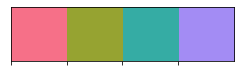

In [10]:
import seaborn as sns

# 視認性の良い4つの色を生成
colors = sns.color_palette('husl', 4)

# カラーマップを表示
sns.palplot(colors)
